In [1]:
!rm -rf sample_data

!git clone https://github.com/gabbiurlaro/aml22-ego.git aml22-ego
!cd aml22-ego && git checkout vae

Cloning into 'aml22-ego'...
remote: Enumerating objects: 3525, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 3525 (delta 103), reused 152 (delta 96), pack-reused 3355
Receiving objects: 100% (3525/3525), 1.51 GiB | 17.81 MiB/s, done.
Resolving deltas: 100% (2576/2576), done.
Updating files: 100% (45/45), done.
Updating files: 100% (159/159), done.
Branch 'vae' set up to track remote branch 'vae' from 'origin'.
Switched to a new branch 'vae'


In [2]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install conda

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [4]:
!mkdir -p /usr/local/envs/egovision
!tar xf /content/drive/MyDrive/egovision.tar.gz --directory=/usr/local/envs/egovision

In [ ]:
%%bash
cd aml22-ego & git pull origin vae

# Augmentation

In [ ]:
import pickle 
import numpy as np
import pandas as pd
import pywt
import torch
import os
import torch.nn.functional as F
from scipy.interpolate import CubicSpline
import random
import torchvision.transforms
from torch.utils.data import Dataset

train =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_train.pkl'))
test =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_test.pkl'))

train

In [26]:
def wavelet_decomposition(signal, wavelet_name, decomposition_level, detail_factor):
    coeffs = pywt.wavedec(signal, wavelet=wavelet_name, level=decomposition_level)
    cA, cD = coeffs[0], coeffs[1:]  # Approximation and detail coefficients
    
    # Modify detail coefficients
    cD_modified = [detail_factor * cd for cd in cD]
    
    # Reconstruct the augmented signal
    augmented_coeffs = [cA] + cD_modified
    augmented_signal = np.array(pywt.waverec(augmented_coeffs, wavelet=wavelet_name))
    
    return augmented_signal


class WaveletDecompositionTransform:
    def __init__(self, wavelet_name, decomposition_level, detail_factor, num_clips):
        self.wavelet_name = wavelet_name
        self.decomposition_level = decomposition_level
        self.detail_factor = detail_factor
        self.num_clips = num_clips
    
    def __call__(self, sample):
        signals = sample['features_EMG']
        augmented_signals = []
        for i in range(self.num_clips):
          augmented_signals.append(wavelet_decomposition(torch.Tensor(signals[i]), self.wavelet_name, self.decomposition_level, self.detail_factor))
        # Create a new augmented sample
        augmented_sample = {
            'features_EMG': np.array(augmented_signals),
            'label': sample['label'],
            'uid': sample['uid'],
            'untrimmed_video_name': sample['untrimmed_video_name']
        }
        
        return augmented_sample

In [27]:
def magnitude_warping(signal, variance=0.01):
    T = signal.size(0)
    t = torch.linspace(0, 1, T)  # Equidistant time points
    r = torch.randn(T)  # Random numbers from a normal distribution
    r = torch.clamp(r, -2.0, 2.0)  # Limit the range of random numbers to avoid extreme warping
    
    # Generate a smooth curve using cubic splines
    spline = CubicSpline(t, r)
    cubic_spline = torch.from_numpy(spline(t)).float()
    
    # Elementwise product of the interpolated curve with the signal
    warped_signal = np.array(signal * (1.0 + variance * cubic_spline))

    return warped_signal

class MagnitudeWarpingTransform:
    def __init__(self, variance, num_clips):
        self.variance= variance
        self.num_clips = num_clips
    
    def __call__(self, sample):
        signals = sample['features_EMG']
        augmented_signals = []
        for i in range(self.num_clips):
          augmented_signals.append(magnitude_warping(torch.Tensor(signals[i]), variance=self.variance))
        # Create a new augmented sample
        augmented_sample = {
            'features_EMG': np.array(augmented_signals),
            'label': sample['label'],
            'uid': sample['uid'],
            'untrimmed_video_name': sample['untrimmed_video_name']
        }
        
        return augmented_sample

# Example usage
#signal = torch.randn(1024)  # Assuming input signal of size 1024
#warped_signal = magnitude_warping(signal, variance=0.01)

In [78]:
class SlidingWindowTransform:
    def __init__(self, window_length, overlap=False, num_clips=5):
        self.window_length = window_length
        self.overlap = overlap
        self.num_clips = num_clips

    def __call__(self, x):
        signals = x['features_EMG']
        for i in range(self.num_clips):
          num_segments = len(signals) // self.window_length
          print( len(signals))
          if self.overlap:
              stride = self.window_length // 2
          else:
              stride = self.window_length
          augmented_signals = []
          for i in range(num_segments):
              start = i * stride
              end = start + self.window_length
              segment = signals[start:end]
              augmented_signals.append(segment)
        augmented_sample = {
              'features_EMG': torch.stack(augmented_signals),
              'label': x['label'],
              'uid': x['uid'],
              'untrimmed_video_name': x['untrimmed_video_name']
          }
        
        return augmented_sample


In [137]:
%cd /content/aml22-ego
sigma = 0.1
wavelet_name = 'db7' #Wavelet name (e.g., Daubechies 4)
decomposition_level = 5 # # Number of decomposition levels
detail_factor = 0 # Scaling factor for modifying detail coefficients
  
num_clips = 5

train =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_train.pkl'))
test =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_test.pkl'))


wavelet_transform = WaveletDecompositionTransform(wavelet_name, decomposition_level, detail_factor, num_clips)
magnitude_warp_transform = MagnitudeWarpingTransform(sigma, num_clips)
#sw_transform = SlidingWindowTransform(window_length=100, overlap=True, num_clips=num_clips)

transforms_A = [
    torchvision.transforms.Compose([wavelet_transform, magnitude_warp_transform]),
     torchvision.transforms.Compose([magnitude_warp_transform ]), 
     torchvision.transforms.Compose([wavelet_transform]),
     torchvision.transforms.Compose([magnitude_warp_transform, wavelet_transform])
    ] 
out_train = {}
out_test = {}
outs = [out_train, out_test]
datasets = [train, test]

for data_id in range(len(datasets)):
  for aug_set in range(4):
    augmented_samples = [transforms_A[aug_set](datasets[data_id]['features'][i]) for i in range(len(datasets[data_id]['features']))]
    outs[data_id][aug_set] = {'features': list(augmented_samples)}
    print(len(outs[data_id][aug_set]['features']))
  #for feats in datasets[data_id]['features']:

ts = ['WD-MW', 'MW', 'WD', 'MW-WD']
for i in range(4):
  filename = './saved_features/aug/ActionNet_augmented_clips_' + ts[i]
  with open(f"{filename}_train.pkl", "wb") as file:
            pickle.dump(outs[0][i], file)
  with open(f"{filename}_test.pkl", "wb") as file:
             pickle.dump(outs[1][i], file)


/content/aml22-ego
526
526
526
526
59
59
59
59


In [167]:
from google.colab import files
!zip -r /content/feats_def.zip /content/aml22-ego/saved_features/aug
files.download('/content/feats_def.zip')

  adding: content/aml22-ego/saved_features/aug/ (stored 0%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_WD-MW_test.pkl (deflated 14%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_WD-MW_train.pkl (deflated 14%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_MW-WD_test.pkl (deflated 14%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_WD_test.pkl (deflated 14%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_MW-WD_train.pkl (deflated 14%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_MW_test.pkl (deflated 10%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_MW_train.pkl (deflated 9%)
  adding: content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_WD_train.pkl (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot features

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
num_clips = 5
# EPIC-KITCHEN and ActionNet

labels = {'EK':{
        0 : "take (get)",
        1 : "put-down (put/place)",
        2 : "open",
        3 : "close",
        4 : "wash (clean)",
        5 : "cut",
        6 : "stir (mix)",
        7 : "pour"
}, 'AN': {
        0 : "Spread",
        1 : "Get/Put",
        2 : "Clear",
        3 : "Slice",
        4 : "Clean",
        5 : "Pour",
        6 : "Load",
        7 : "Peel",
        8 : "Open/Close",
        9 : "Set",
        10 : "Stack",
        11 : "Unload"

}}

colors = {'EK': {
        0 : "#A52A2A",
        1 : "#DAA520",
        2 : "#FF7F50",
        3 : "#7BC8F6",
        4 : "#FFFF14",
        5 : "#76FF7B",
        6 : "#13EAC9",
        7 : "olive"
}, 'AN': {
        0 : "#A52A2A",
        1 : "#DAA520",
        2 : "#FF7F50",
        3 : "#7BC8F6",
        4 : "#FFFF14",
        5 : "#76FF7B",
        6 : "#13EAC9",
        7 : "olive",
        8 : "palegreen",
        9 : "lightpink",
        10 : "darkmagenta",
        11 : "cadetblue"
}}

In [21]:
data_original = pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_train.pkl')["features"])
data = pd.DataFrame(pd.read_pickle("/content/aml22-ego/saved_features/reconstructed/AUG_VAE_0.001_2023-05-24 16:15:44.696068_train.pkl")["features"])


In [ ]:
data.iloc[0]
ts = ['WD-MW', 'MW', 'WD', 'MW-WD']
data_augmented_train = []
for i in range(4):
  data_augmented_train.append(pd.read_pickle('/content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_'+ ts[i]+'_train.pkl'))
data = pd.DataFrame(data_augmented_train[3]['features'] +data_augmented_train[2]['features']+
                   data_augmented_train[1]['features'] +
                    data_augmented_train[0]['features'] + data_original['features'])
len(data)

5


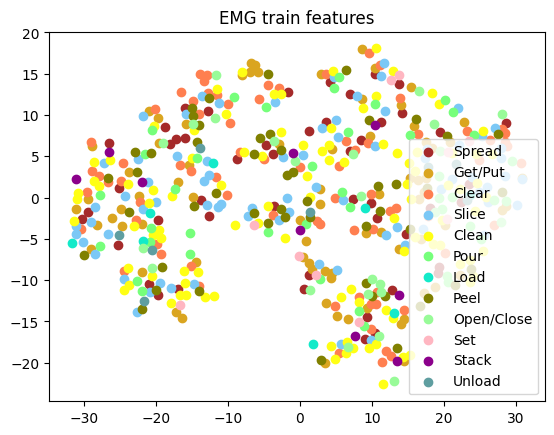

In [22]:
# plot emg features
print(len(data.iloc[0]['features_EMG']))
features = np.array([data.iloc[i].features_EMG[num_clips//2] for i in range(len(data))])
reduced = TSNE().fit_transform(features)
data['x'] = reduced[:, 0]
data['y'] = reduced[:, 1]
for i in range(12): # ek has 8 classes
    filtered = data[data["label"] == i]
    # compute the central frame
    plt.scatter(filtered['x'], filtered['y'], c=colors['AN'][i], label=labels['AN'][i])
plt.legend()
plt.title('EMG train features')
plt.show()

# Train VAE

In [ ]:
%%bash
#VAE EMG train and save

cd aml22-ego && git pull origin vae

PYTHON_PATH=/usr/local/envs/egovision/bin/python

$PYTHON_PATH train_VAE_features_EMG.py action="train_and_save" \
  name="VAE_EMG_2 full-aug lr1e-3 wkld1 sum" \
  config=configs/VAE_save_feat_EMG.yaml \
  dataset.shift=ActionNet-ActionNet \
  wandb_name='vae' \
  wandb_dir='Experiment_logs'  \
  dataset.RGB.data_path=../ek_data/frames \
  dataset.EMG.features_name='ACTIONNET_EMG/EMG_no-clip' \
  models.EMG.model='VAE' \
  models.EMG.lr=1e-3